
📊 Processing Memory Utilization with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 10 outliers using 4 features (3% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 10 outliers using 4 features (3% contamination rate)

📊 Processing Memory Cache with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 10 outliers using 4 features (3% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 10 outliers using 4 features (3% contamination rate)

📊 Processing Memory Available with Isolation Forest:
  🔍 CPU STRESS:
    ✅ Cleaned 10 outliers using 4 features (3% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 10 outliers using 4 features (3% contamination rate)

COMPREHENSIVE MEMORY CPU STRESS ANALYSIS - ISOLATION FOREST

🔄 Analyzing Memory Utilization...


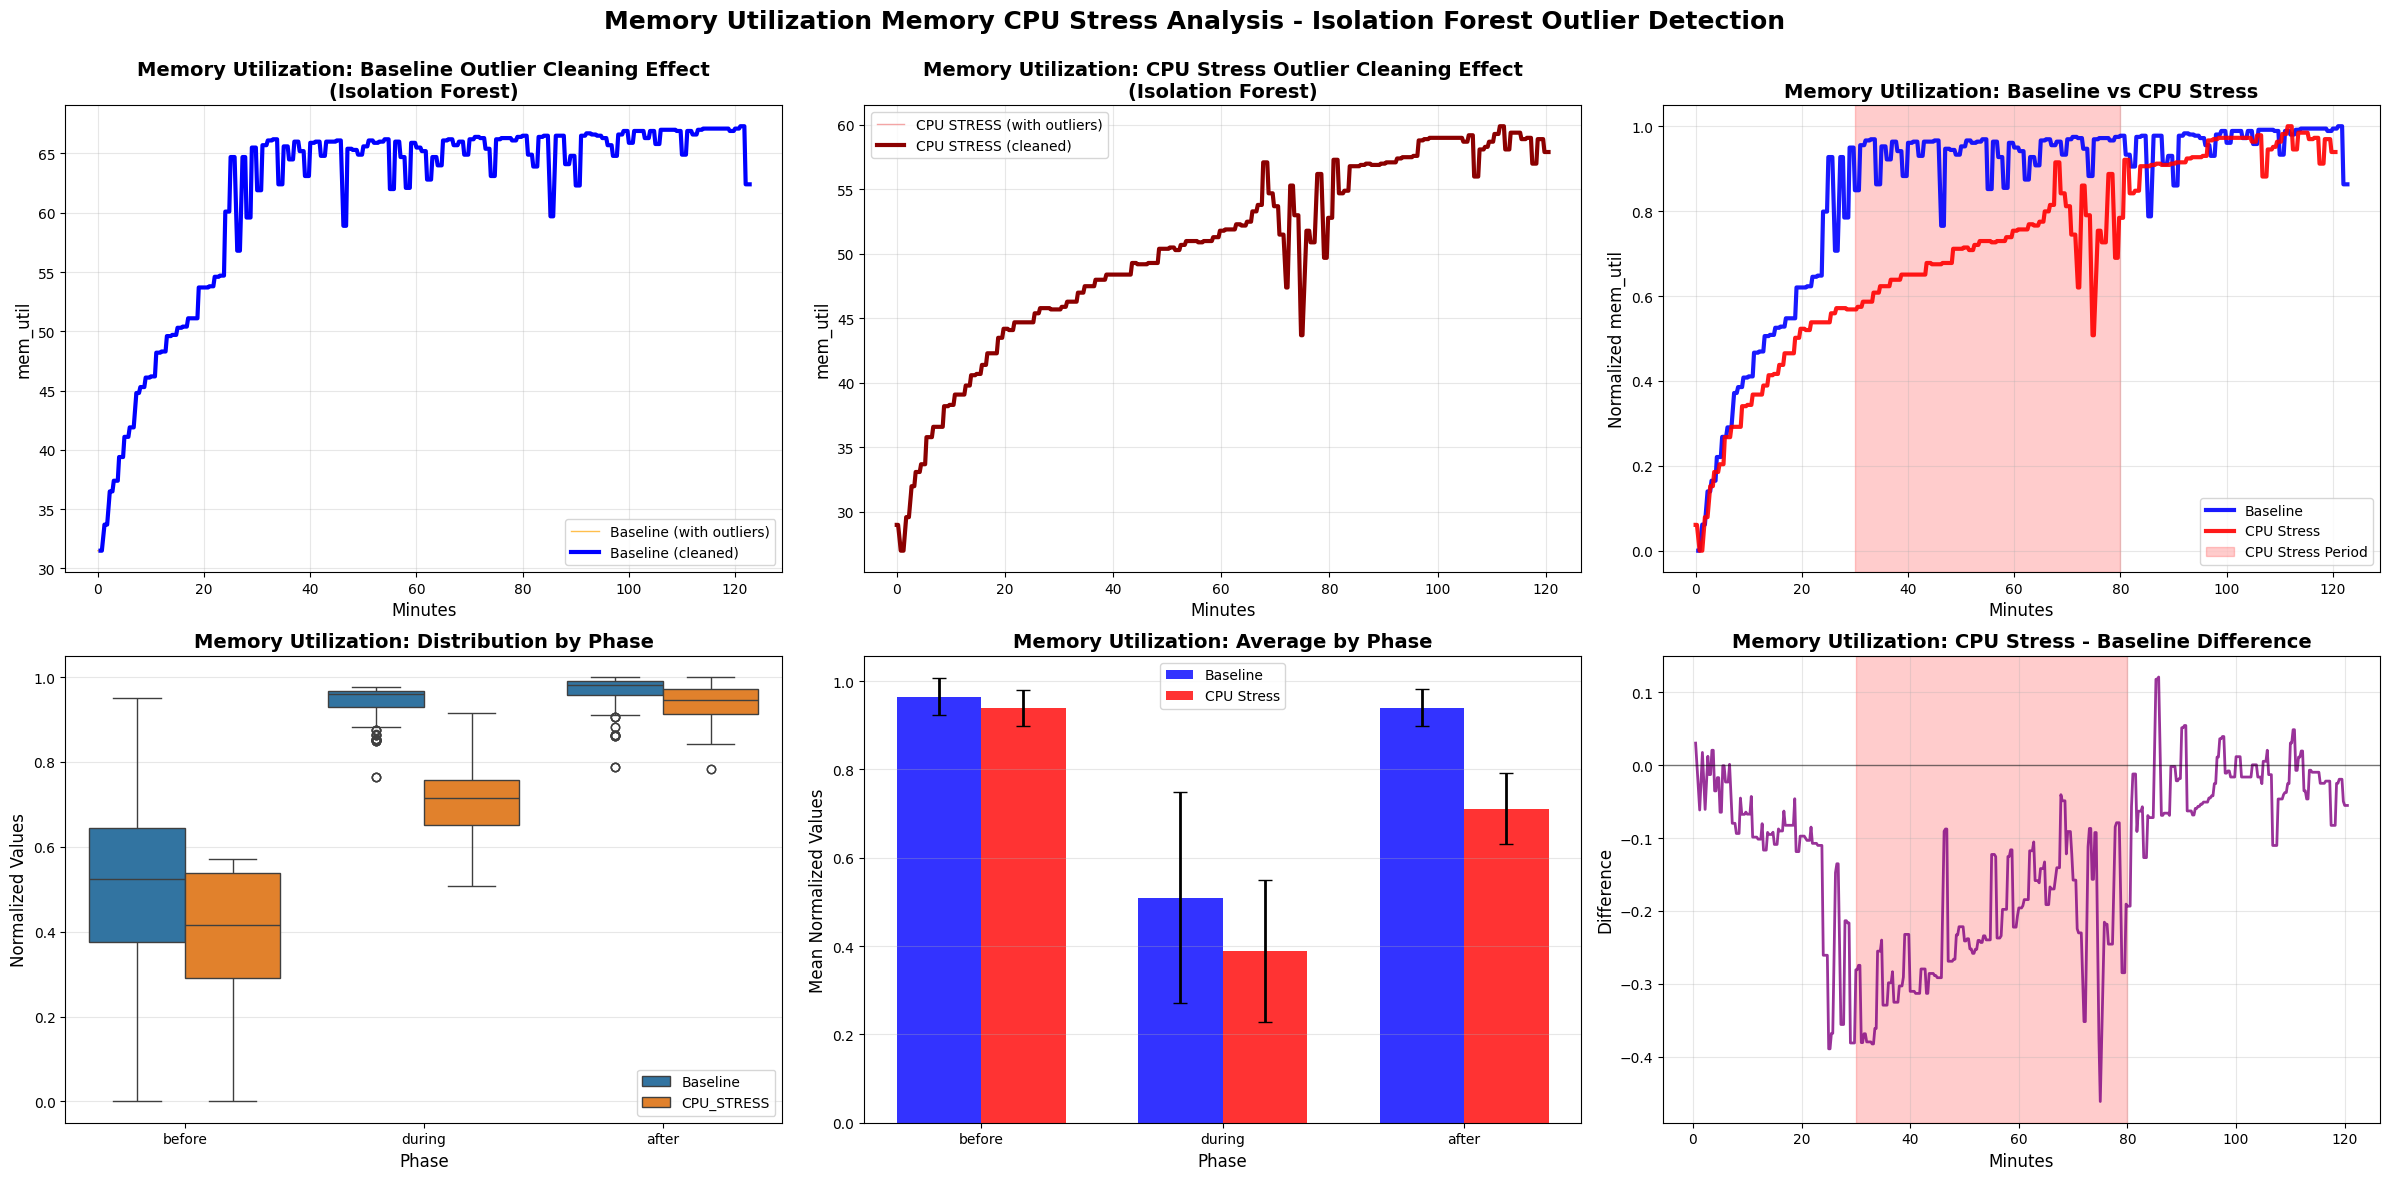


MEMORY UTILIZATION - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9648  0.0420  0.7877  1.0000
before  0.5099  0.2386  0.0000  0.9497
during  0.9400  0.0415  0.7654  0.9777

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9392  0.0407  0.7842  1.0000
before  0.3893  0.1610  0.0000  0.5714
during  0.7113  0.0804  0.5076  0.9149

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  4.58, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 35.84, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=  5.65, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON MEMORY (% CHANGE):
  BEFORE  :  -23.65% (↘️ DECREASE)
  DURING  :  -24.32% (↘️ DECREASE)
  AFTER   :   -2.66% (↘️ DECREASE)

🔄 Analyzing Memory Cache...


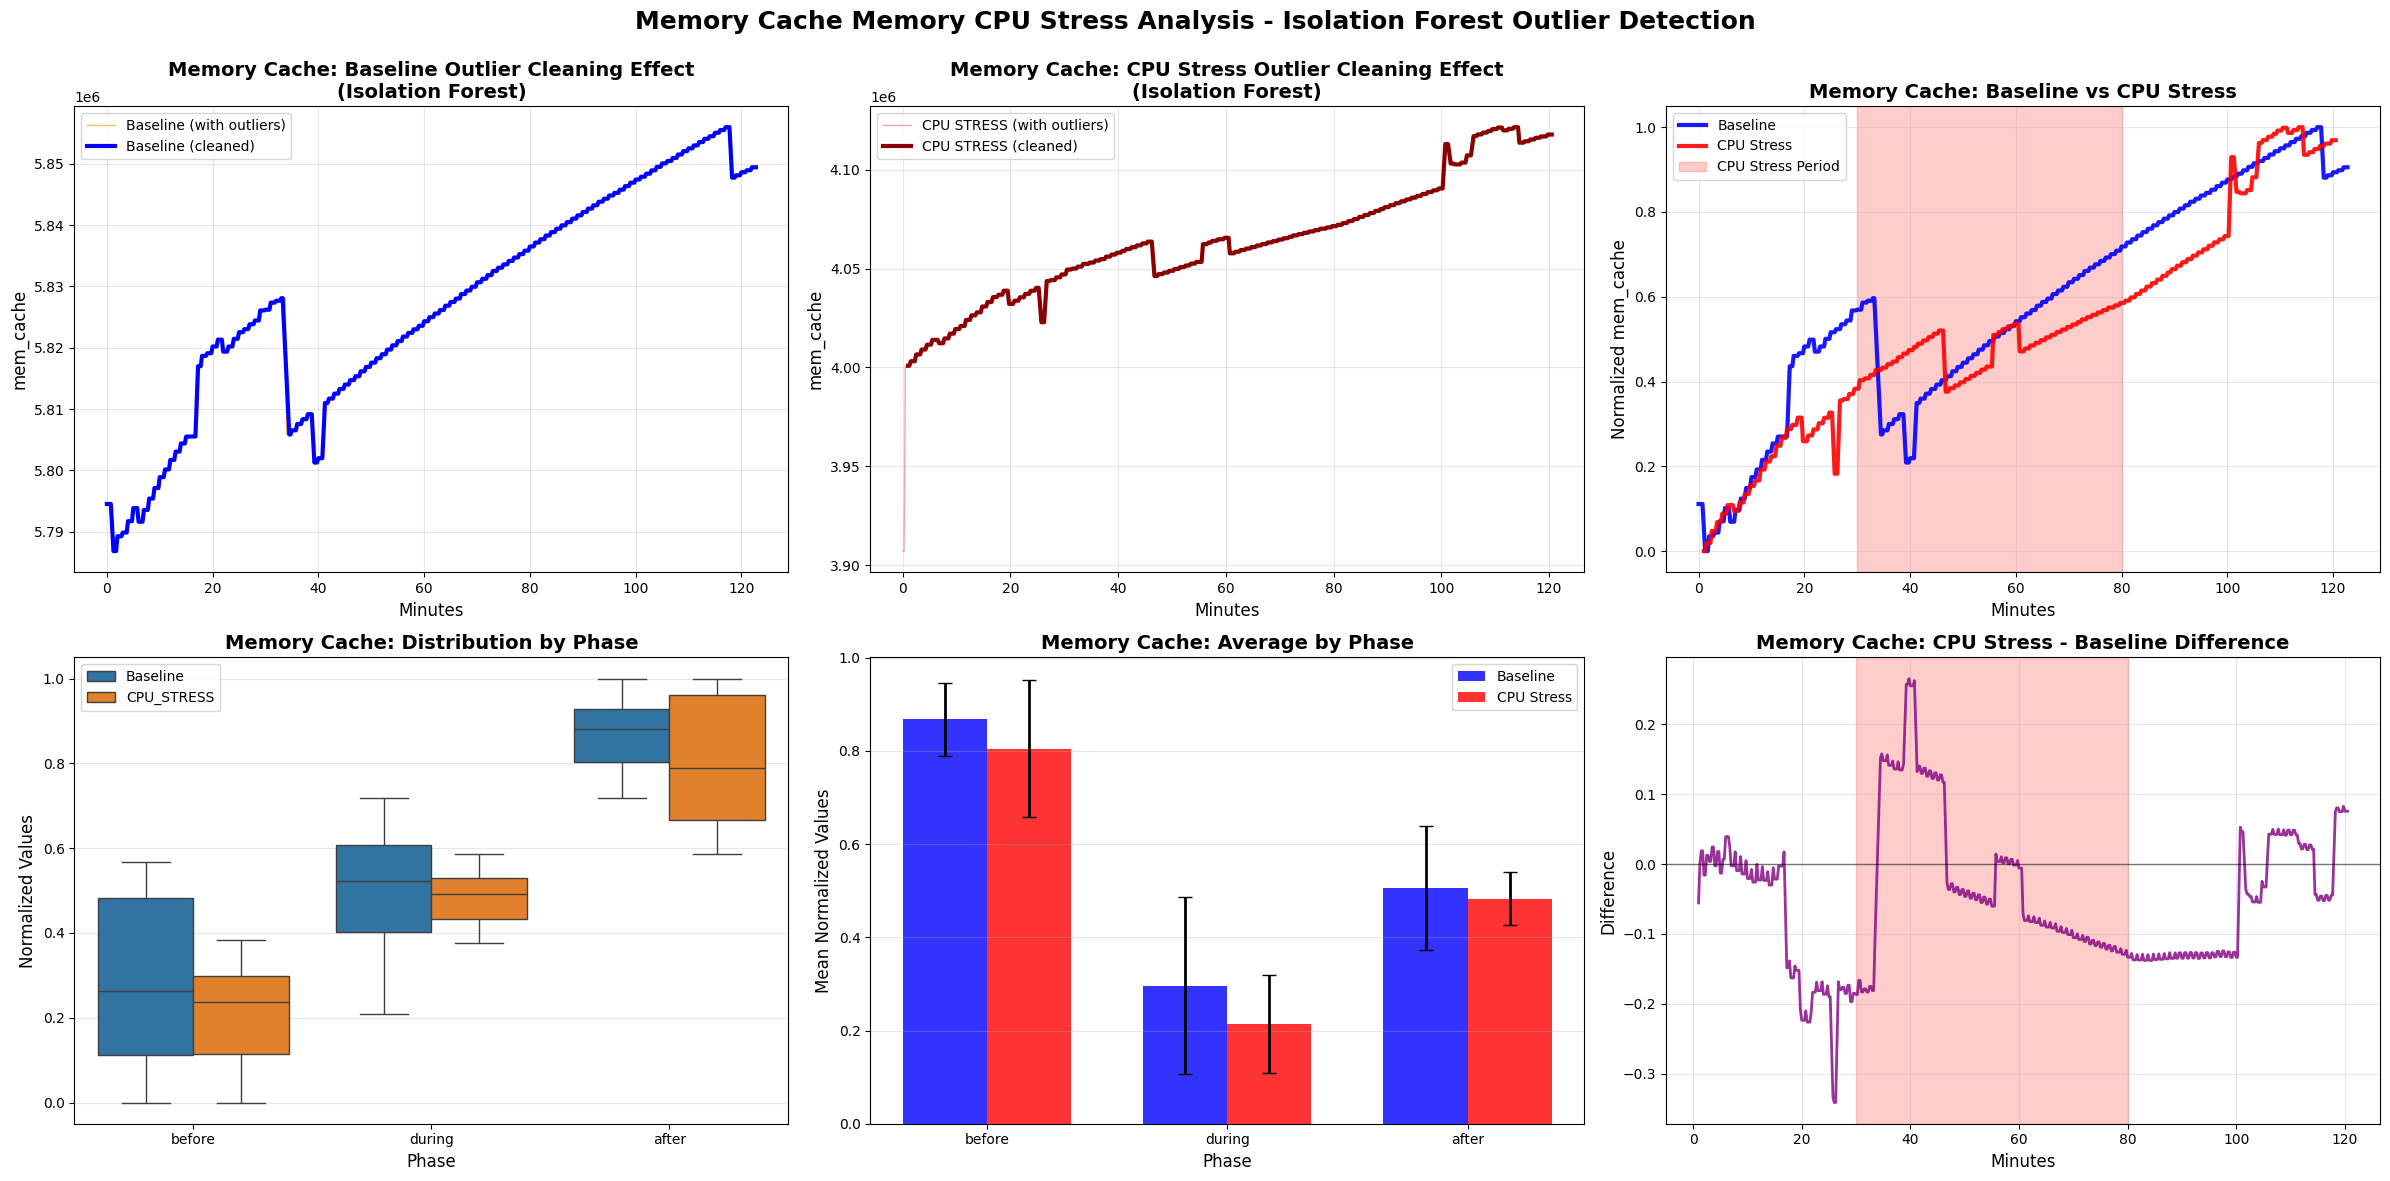


MEMORY CACHE - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8680  0.0786  0.7186  1.0000
before  0.2964  0.1891  0.0000  0.5677
during  0.5058  0.1329  0.2089  0.7186

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8050  0.1478  0.5854  1.0000
before  0.2138  0.1052  0.0000  0.3829
during  0.4831  0.0572  0.3760  0.5854

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  4.12, p=  0.0001 (✅ SIGNIFICANT)
  DURING  : t=  2.22, p=  0.0267 (✅ SIGNIFICANT)
  AFTER   : t=  4.89, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON MEMORY (% CHANGE):
  BEFORE  :  -27.84% (↘️ DECREASE)
  DURING  :   -4.49% (↘️ DECREASE)
  AFTER   :   -7.25% (↘️ DECREASE)

🔄 Analyzing Memory Available...


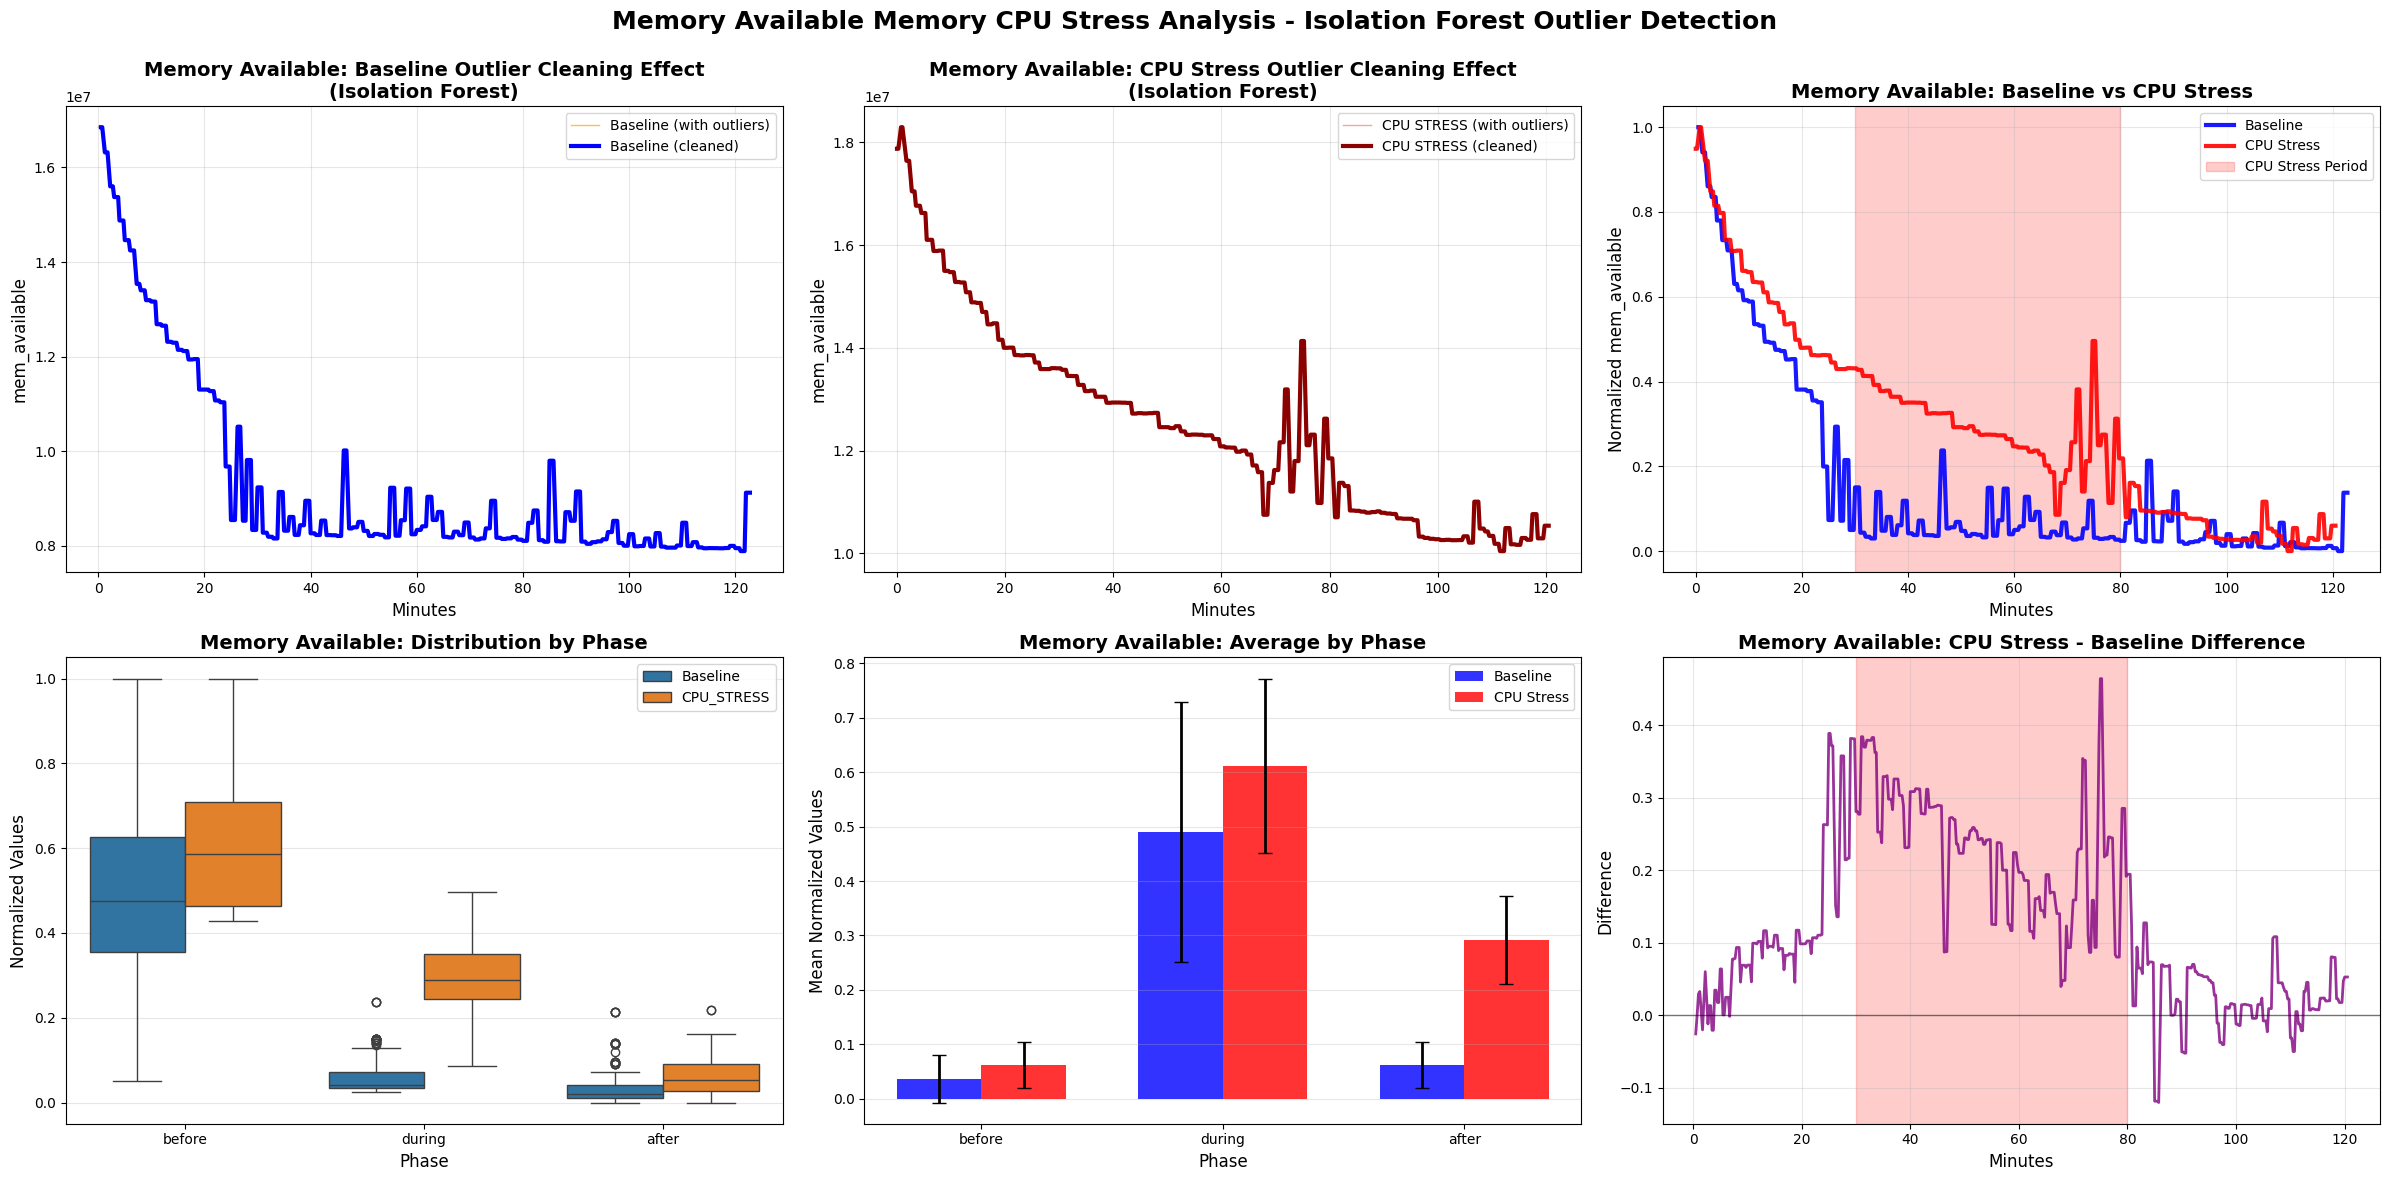


MEMORY AVAILABLE - CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0365  0.0437  0.0000  0.2132
before  0.4903  0.2390  0.0498  1.0000
during  0.0616  0.0421  0.0241  0.2374

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0617  0.0421  0.0000  0.2187
before  0.6114  0.1606  0.4293  1.0000
during  0.2915  0.0813  0.0857  0.4956

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -4.59, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-35.58, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -5.35, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON MEMORY (% CHANGE):
  BEFORE  :  +24.69% (↗️ INCREASE)
  DURING  : +372.86% (↗️ INCREASE)
  AFTER   :  +69.01% (↗️ INCREASE)

COMPREHENSIVE MEMORY CPU STRESS IMPACT SUMMARY
     Memory_Metric        Phase   Impact (%)      P-Value  Significant  T-Statistic
Memory Utilization       before 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all memory datasets
df_mem_util = pd.read_csv("mem_util.csv")
df_mem_cache = pd.read_csv("mem_cache.csv")
df_mem_available = pd.read_csv("mem_available.csv")

df_baseline_mem_util = pd.read_csv("../../baseline/memory related/mem_util.csv")
df_baseline_mem_cache = pd.read_csv("../../baseline/memory related/mem_cache.csv")
df_baseline_mem_available = pd.read_csv("../../baseline/memory related/mem_available.csv")

# Add source labels for CPU STRESS experiment
df_mem_util["source"] = "CPU_STRESS"
df_mem_cache["source"] = "CPU_STRESS"
df_mem_available["source"] = "CPU_STRESS"

df_baseline_mem_util["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_available["source"] = "BASELINE"

# Convert to datetime
df_mem_util["Time"] = pd.to_datetime(df_mem_util["Time"])
df_mem_cache["Time"] = pd.to_datetime(df_mem_cache["Time"])
df_mem_available["Time"] = pd.to_datetime(df_mem_available["Time"])

df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_mem_util["Time"].min() - df_mem_util["Time"].min()
df_mem_util["Time"] += time_offset
df_mem_cache["Time"] += time_offset
df_mem_available["Time"] += time_offset

# Convert timeline to minutes
all_dfs = [
    df_mem_util, df_mem_cache, df_mem_available,
    df_baseline_mem_util, df_baseline_mem_cache, df_baseline_mem_available
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY
original_datasets = {
    'Memory Utilization': {'cpu_stress': df_mem_util, 'baseline': df_baseline_mem_util},
    'Memory Cache': {'cpu_stress': df_mem_cache, 'baseline': df_baseline_mem_cache},
    'Memory Available': {'cpu_stress': df_mem_available, 'baseline': df_baseline_mem_available}
}

# ISOLATION FOREST OUTLIER DETECTION FOR MEMORY METRICS
def remove_outliers_isolation_forest_memory(df, contamination=0.02):

    df_clean = df.copy()
    outlier_stats = {}
    
    # Get all numeric columns except Time, Minutes, and source
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return df_clean, outlier_stats
    
    # Create feature matrix - for memory we might have fewer features than CPU
    if len(numeric_cols) == 1:
        # Single metric - use univariate approach with some derived features
        main_col = numeric_cols[0]
        series = df[main_col].fillna(method='ffill').fillna(method='bfill')
        
        # Create additional features for better outlier detection
        features = []
        features.append(series.values)  # Original values
        
        # Add rolling statistics as features 
        features.append(series.rolling(5, center=True).mean().fillna(method='ffill').fillna(method='bfill').values)
        features.append(series.rolling(5, center=True).std().fillna(0).values)
        features.append(series.diff().fillna(0).values)  # Rate of change
        
        feature_matrix = np.column_stack(features)

    
    # Scale features for better performance
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Initialize and fit Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit and predict
    iso_forest.fit(feature_matrix_scaled)
    outlier_predictions = iso_forest.predict(feature_matrix_scaled)
    
    # Create outlier mask (-1 = outlier, 1 = normal)
    outlier_mask = outlier_predictions == -1
    
    # Apply outlier removal to each numeric column
    for col in numeric_cols:
        outlier_stats[col] = {
            'count': outlier_mask.sum(),
            'percentage': (outlier_mask.sum() / len(df[col])) * 100,
            'method': 'isolation_forest'
        }
        
        # Set outliers to NaN and interpolate
        df_clean.loc[outlier_mask, col] = np.nan
        df_clean[col] = df_clean[col].interpolate(method='linear')
    
    # Overall statistics
    outlier_stats['_summary'] = {
        'total_outliers': outlier_mask.sum(),
        'contamination_rate': contamination,
        'method': 'isolation_forest_memory',
        'features_used': feature_matrix.shape[1]
    }
    
    return df_clean, outlier_stats

# OUTLIER CLEANING
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with Isolation Forest:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Apply Isolation Forest outlier detection (lower contamination for memory)
        df_clean, stats = remove_outliers_isolation_forest_memory(df, contamination=0.02)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        # Print outlier summary
        total_outliers = stats['_summary']['total_outliers']
        features_used = stats['_summary']['features_used']
        print(f"    ✅ Cleaned {total_outliers} outliers using {features_used} features (3% contamination rate)")

# NORMALIZATION FUNCTION
def normalize_df_memory(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ANALYSIS AND PLOT FUNCTION FOR MEMORY METRICS
def analyze_and_plot_memory_dataset_wide(dataset_name, cpu_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Get numeric columns for memory metrics
    numeric_cols = [col for col in cpu_stress_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    cpu_stress_norm = normalize_df_memory(cpu_stress_df, numeric_cols)
    baseline_norm = normalize_df_memory(baseline_df, numeric_cols)
    
    # For memory metrics, we typically have single metrics, so we'll use the main metric
    main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        print(f"No numeric columns found for {dataset_name}")
        return None
    
    # Add phase information
    cpu_stress_norm = add_phase_column(cpu_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_cpu_stress = cpu_stress_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'CPU_STRESS': cpu_stress_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpu_stress_norm[main_metric] - baseline_norm[main_metric]
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpu_stress_mean = stats_cpu_stress.loc[phase, 'mean']
        impact[phase] = ((cpu_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING (all original plots preserved)
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[main_metric], 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df[main_metric], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect\n(Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'{main_metric}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS outlier cleaning effect
    plt.subplot(2, 3, 2)
    original_cpu_stress = original_datasets[dataset_name]['cpu_stress']
    
    plt.plot(original_cpu_stress['Minutes'], original_cpu_stress[main_metric], 
             label='CPU STRESS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpu_stress_df['Minutes'], cpu_stress_df[main_metric], 
             label='CPU STRESS (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress Outlier Cleaning Effect\n(Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'{main_metric}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpu_stress_norm['Minutes'], cpu_stress_norm[main_metric], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpu_stress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpu_stress['mean'], yerr=stats_cpu_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: CPU Stress - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} Memory CPU Stress Analysis - Isolation Forest Outlier Detection', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - CPU STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpu_stress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT ON MEMORY (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpu_stress': stats_cpu_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric
    }

# RUN ANALYSIS 
print(f"\n{'='*80}")
print("COMPREHENSIVE MEMORY CPU STRESS ANALYSIS - ISOLATION FOREST")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpu_stress_clean = datasets_clean[dataset_name]['cpu_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_memory_dataset_wide(
        dataset_name, 
        cpu_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )

# FINAL COMPREHENSIVE SUMMARY
print(f"\n{'='*100}")
print("COMPREHENSIVE MEMORY CPU STRESS IMPACT SUMMARY")
print(f"{'='*100}")

summary_table = []
for dataset_name, results in analysis_results.items():
    if results:  # Check if analysis was successful
        for phase in ['before', 'during', 'after']:
            summary_table.append({
                'Memory_Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{results['impact'][phase]:+.1f}%",
                'P-Value': f"{results['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if results['t_tests'][phase]['p'] < 0.05 else 'NO',
                'T-Statistic': f"{results['t_tests'][phase]['t']:.2f}"
            })

if summary_table:
    summary_df = pd.DataFrame(summary_table)
    print(summary_df.to_string(index=False, col_space=12))